In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
from sys import platform
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
if platform == "linux" or platform == "linux2":
    dir_folder = Path('/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/')
elif platform == 'win32':
    dir_folder = Path('U:\\Takashi') # put folder for windows system
dir_curr = Path('depreciated/spikes/')
vol_file = Path('depreciated/analysis_sections_based_on_swim_pattern.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')

In [46]:
nfish = 0
ncell_ = 15
row = dat_xls_file.iloc[nfish]
folder = row['folder']
fish = row['fish']
# print(f'Processing {folder} {fish}')
dat_dir = dir_folder/f'{folder}/{fish}/Data/'
swim_dir = dir_folder/f'{folder}/{fish}/swim/'
dff = np.load(dat_dir/'Voltr_spikes.npz')['voltrs']
dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
spk = np.load(dat_dir/'Voltr_spikes.npz')['spk']
spkprobs = np.load(dat_dir/'Voltr_spikes.npz')['spkprob']
num_cell = spk.shape[0]
# spk with padding zeros for the first 2 seconds
spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
spkprobs = np.r_['-1', np.zeros((num_cell, 600)), spkprobs]
frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')

_ = np.load(f'swim_power/{folder}_{fish}_swim_dat.npz')
swim_starts = _['swim_starts']
swim_ends = _['swim_ends']
r_swim = _['r_swim']
l_swim = _['l_swim']
visu = _['visu']
task_period = _['task_period']
swim_task_index = _['swim_task_index']

p_swim = np.sqrt(r_swim**2+l_swim**2)
# for n_ in range(p_swim.shape[0]):
#     s_len = swim_ends[n_] - swim_starts[n_]
#     p_swim[n_, 100+s_len:] = np.nan

n_task = task_period.max().astype('int')
swim_task_index_ = (swim_task_index-1)%n_task+1
swim_bout_index_task = np.zeros(len(swim_task_index_)).astype('int')
swim_bout_index_task[0] = 1
for n_bout in range(len(swim_task_index_)-1):
    if swim_task_index_[n_bout] == swim_task_index_[n_bout-1]:
        swim_bout_index_task[n_bout] = swim_bout_index_task[n_bout-1]+1
    else:
        swim_bout_index_task[n_bout] = 1

swim_bout_index_task = swim_bout_index_task

# plt.plot(np.arange(350)/300-50/300, np.nanmean(p_swim[task_period==1, :], axis=0), '-k')
# plt.plot(np.arange(350)/300-50/300, np.nanmean(p_swim[task_period==2, :], axis=0), '-r')
# plt.ylabel('Swim power')
# plt.xlabel('Time (sec)')
# plt.xlim([-50/300, 250/300])
# # plt.ylim([0, 160])
# # plt.vlines([0], [0], [320], colors='k', linestyles='--')
# sns.despine()
# plt.show()

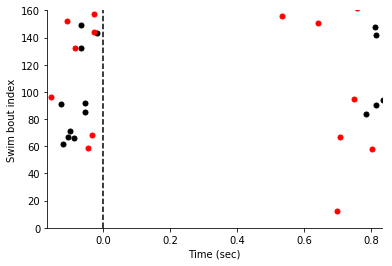

In [47]:
spk_list = np.zeros((r_swim.shape[0], 400))
spkprobs_list = np.zeros((r_swim.shape[0], 400))
for n_cell in range(spk_list.shape[0]):
    if n_cell != ncell_:
        continue
    for n, n_swim in enumerate(swim_starts):
        try:
            spk_list[n, :] = spk[n_cell, n_swim-100:n_swim+300] 
            spkprobs_list[n, :] = spkprobs[n_cell, n_swim-100:n_swim+300] 
        except:
            pass
    plt_raster(spk_list[task_period==1, :], c='k')
    plt_raster(spk_list[task_period==2, :], c='r')
    # plt.title(f'Cell #{n_cell}')
    plt.ylabel('Swim bout index')
    plt.xlabel('Time (sec)')
    plt.xlim([-50/300, 250/300])
    plt.ylim([0, 160])
    plt.vlines([0], [0], [320], colors='k', linestyles='--')
    sns.despine()
    plt.show()

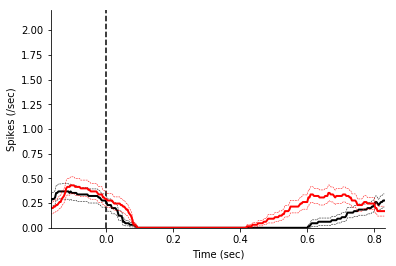

In [48]:
# k_ = gaussKernel(sigma=20)
k_ = boxcarKernel(sigma=60)
# ave_ = spk_list[task_period==1, :].mean(axis=0)*300
ave_ = []
for n_spk in spk_list[task_period==1, :]*300:
    ave_.append(smooth(n_spk, k_))
ave_ = np.array(ave_)
mean_ = ave_[:, 50:350].mean(axis=0)
std_ = ave_[:, 50:350].std(axis=0)/np.sqrt(ave_.shape[0])
plt.plot(np.arange(300)/300-50/300, mean_, '-k', lw=2)
plt.plot(np.arange(300)/300-50/300, mean_-std_, '--k', lw=0.5)
plt.plot(np.arange(300)/300-50/300, mean_+std_, '--k', lw=0.5)


ave_ = []
for n_spk in spk_list[task_period==2, :]*300:
    ave_.append(smooth(n_spk, k_))
ave_ = np.array(ave_)
mean_ = ave_[:, 50:350].mean(axis=0)
std_ = ave_[:, 50:350].std(axis=0)/np.sqrt(ave_.shape[0])
plt.plot(np.arange(300)/300-50/300, mean_, '-r', lw=2)
plt.plot(np.arange(300)/300-50/300, mean_-std_, '--r', lw=0.5)
plt.plot(np.arange(300)/300-50/300, mean_+std_, '--r', lw=0.5)

plt.ylim([0, 2.2])
plt.xlim([-50/300, 250/300])
plt.vlines([0], [0], [2.2], colors='k', linestyles='--')

plt.xlabel('Time (sec)')
plt.ylabel('Spikes (/sec)')
sns.despine()

In [49]:
from scipy.signal import medfilt

subvolt = dff.copy()
for n, ndff in enumerate(dff):
    subvolt[n, :] = medfilt(ndff, kernel_size=9)

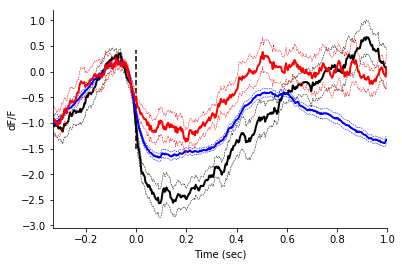

In [50]:
sub_list = np.zeros((r_swim.shape[0], 400))
trial_valid_ = np.ones(r_swim.shape[0]).astype('bool')
for n_cell in range(spk_list.shape[0]):
    if n_cell != ncell_:
        continue
    for n, n_swim in enumerate(swim_starts):
        sub_list[n, :] = subvolt[n_cell, n_swim-100:n_swim+300] 
        sub_list[n, :] = sub_list[n, :] - sub_list[n, 70:100].mean()
        late_swim = np.where(p_swim[n]>0)[0]
        if (late_swim>200).sum()>0:
            trial_valid_[n] = False

t_min = 0
t_max = 400
ave_ = sub_list[(task_period==1) & trial_valid_, :]*100
mean_ = np.nanmean(ave_[:, t_min:t_max], axis=0)
max_ = mean_.max()
min_ = mean_.min()
std_ = np.nanstd(ave_[:, t_min:t_max], axis=0)/np.sqrt(ave_.shape[0])
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_, '-k', lw=2)
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_-std_, '--k', lw=0.5)
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_+std_, '--k', lw=0.5)


ave_ = sub_list[(task_period==1) & ~trial_valid_, :]*100
mean_ = np.nanmean(ave_[:, t_min:t_max], axis=0)
max_ = mean_.max()
min_ = mean_.min()
std_ = np.nanstd(ave_[:, t_min:t_max], axis=0)/np.sqrt(ave_.shape[0])
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_, '-b', lw=2)
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_-std_, '--b', lw=0.5)
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_+std_, '--b', lw=0.5)

ave_ = sub_list[(task_period==2) & trial_valid_, :]*100
ave_ = ave_[np.isnan(ave_).sum(axis=-1)==0, :]
mean_ = np.nanmean(ave_[:, t_min:t_max], axis=0)
max_ = mean_.max()
min_ = mean_.min()
std_ = np.nanstd(ave_[:, t_min:t_max], axis=0)/np.sqrt(ave_.shape[0])
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_, '-r', lw=2)
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_-std_, '--r', lw=0.5)
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_+std_, '--r', lw=0.5)

# plt.ylim([0, 2.2])
plt.xlim([-(100-t_min)/300, (t_max-100)/300])
plt.vlines([0], [min_-np.abs(min_)*0.1], [max_+np.abs(max_)*0.1], colors='k', linestyles='--')
plt.xlabel('Time (sec)')
plt.ylabel('dF/F')
sns.despine()

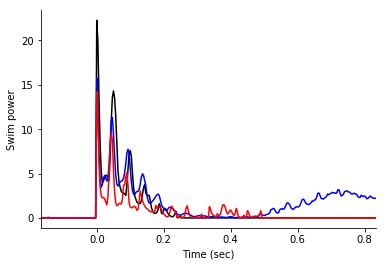

In [51]:
plt.plot(np.arange(350)/300-50/300, np.nanmean(p_swim[(task_period==1) & trial_valid_, :], axis=0), '-k')
plt.plot(np.arange(350)/300-50/300, np.nanmean(p_swim[(task_period==1) & ~trial_valid_, :], axis=0), '-b')
plt.plot(np.arange(350)/300-50/300, np.nanmean(p_swim[(task_period==2) & trial_valid_, :], axis=0), '-r')
plt.ylabel('Swim power')
plt.xlabel('Time (sec)')
plt.xlim([-50/300, 250/300])
# plt.ylim([0, 160])
# plt.vlines([0], [0], [320], colors='k', linestyles='--')
sns.despine()
plt.show()

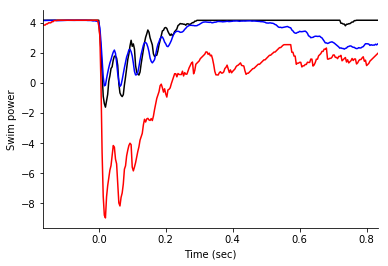

In [52]:
plt.plot(np.arange(350)/300-50/300, np.nanmean(visu[(task_period==1) & trial_valid_, :], axis=0), '-k')
plt.plot(np.arange(350)/300-50/300, np.nanmean(visu[(task_period==1) & ~trial_valid_, :], axis=0), '-b')
plt.plot(np.arange(350)/300-50/300, np.nanmean(visu[(task_period==2) & trial_valid_, :], axis=0), '-r')
plt.ylabel('Swim power')
plt.xlabel('Time (sec)')
plt.xlim([-50/300, 250/300])
# plt.ylim([0, 160])
# plt.vlines([0], [0], [320], colors='k', linestyles='--')
sns.despine()
plt.show()

In [53]:
from sklearn.linear_model import LinearRegression, HuberRegressor, RidgeCV, Ridge

In [54]:
def get_trial(sub_list, task_period, p_swim):
    win_ = 5
    x = []
    y = []
    for n in range(sub_list.shape[0]):
        for ntime in range(40, 300):
            x_ = sub_list[n, ntime+50-1]
            # m_1 = (p_swim[n, ntime-win_:ntime+win_]>0) & (np.array([task_period[n]==1]*win_*2))
            # m_2 = (p_swim[n, ntime-win_:ntime+win_]>0) & (np.array([task_period[n]==2]*win_*2))
            # x.append(np.r_[(x_, m_1, m_2)])
            if task_period[n]==1:
                _ = np.array([1, 0])
            if task_period[n]==2:
                _ = np.array([0, 1])
            if task_period[n]>2:
                continue
            m = _*p_swim[n, ntime]
            v = _*np.max(-visu[n, ntime], 0)
            x.append(np.r_[(x_, m, v)])
            y.append(sub_list[n, ntime+50])
    return np.array(x), np.array(y)

In [55]:
X, y = get_trial(sub_list, task_period, p_swim)

In [56]:
reg = LinearRegression(fit_intercept=True)

In [57]:
len_X = X.shape[0]
reg.fit(X[:len_X//2], y[:len_X//2])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [58]:
print(reg.coef_)
print(reg.intercept_)

[ 9.85498795e-01 -2.54371386e-05 -1.80022178e-05 -2.47021365e-05
 -1.92655055e-05]
-0.00021253549739401467


In [59]:
y_bar = reg.predict(X)

In [60]:
reg.score(X, y)

0.9721950997034718

In [61]:
1/(1-reg.coef_[0])*1000/300

229.86595394722133

In [45]:
y_bar_ = y_bar.reshape(-1, 260)
plt.plot(y_bar_[task_period==1].mean(axis=0))
plt.plot(y_bar_[task_period==2].mean(axis=0))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 454 but corresponding boolean dimension is 514

(0, 100)

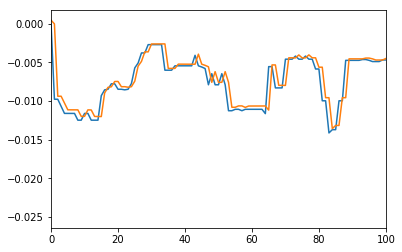

In [111]:
plt.plot(sub_list[15][90:])
plt.plot(y_bar_[15])
plt.xlim([0, 100])